#preprocessing

In [36]:
import pandas as pd

# Load dataset
data = pd.read_csv("MarketPricePrediction.csv")


In [37]:
#handle missing values by dropping rows with missing values
data.dropna(inplace=True)

In [38]:
#encoding categorical variables
data=pd.get_dummies(data,columns=["market","state","city"])

In [39]:
# Handle date (consider using year-month or full date)
data["date"] = pd.to_datetime(data["date"],format='%B-%Y')
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month

In [40]:
#scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[['quantity', 'priceMin', 'priceMax', 'priceMod']] = scaler.fit_transform(data[['quantity', 'priceMin', 'priceMax', 'priceMod']])

In [41]:
#setting target variable and split into training and test sets
target = "priceMod"
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(target,axis=1), data[target], test_size=0.2, random_state=42)

#EDA

In [42]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

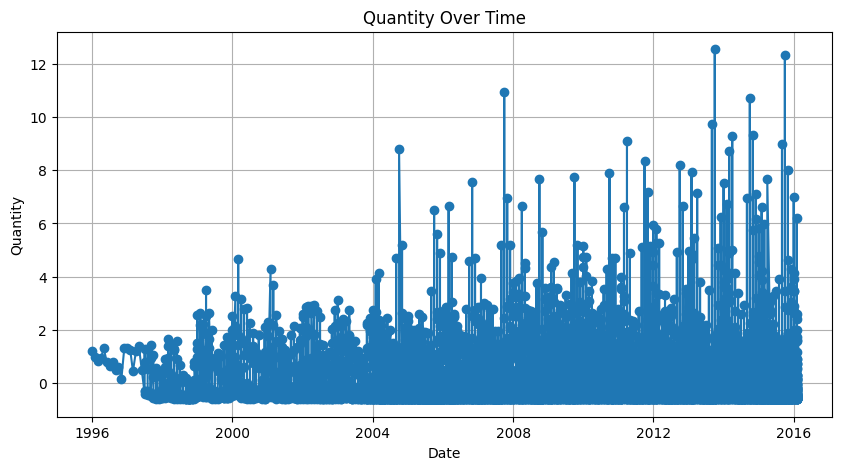

In [45]:
# Sort data by 'date'
data.sort_values('date', inplace=True)

# Set 'date' as the index
data.set_index('date', inplace=True)

# Plot quantity over time as temporal pattern
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['quantity'], marker='o', linestyle='-')
plt.title('Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()

In [46]:
#perform decomposition
decomposition = seasonal_decompose(data['priceMod'], model='additive', period=12)  # Assuming seasonality period is 12 months

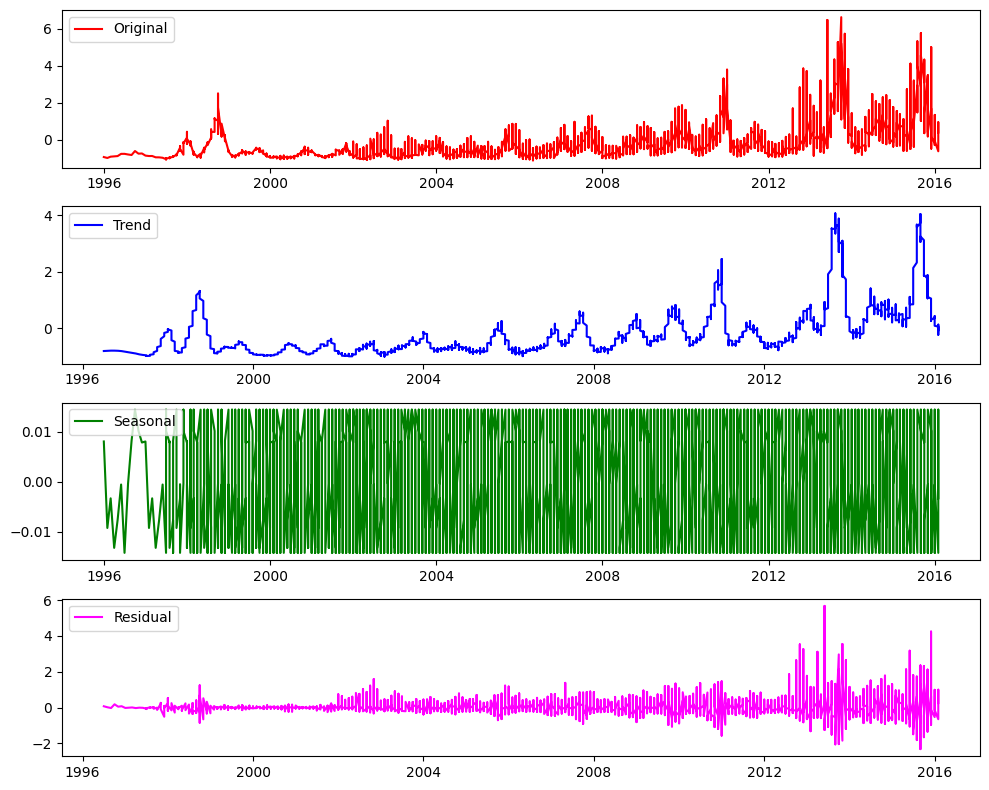

In [49]:
#identify seasonality,trends,anomalies
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(data['priceMod'], label='Original', color='red')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='magenta')
plt.legend(loc='upper left')
plt.tight_layout()

<Figure size 1000x400 with 0 Axes>

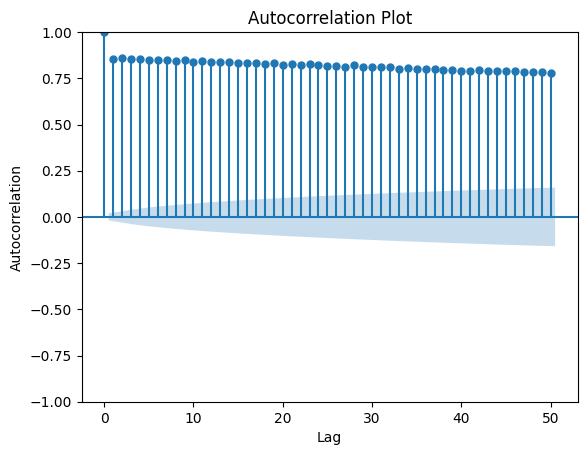

In [50]:
#autocorrelation plotting
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 4))
plot_acf(data['priceMod'], lags=50, alpha=0.05)
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

#feature engineering

In [53]:
# Create lagged variables
data['lag_1'] = data['quantity'].shift(1)
data['lag_2'] = data['quantity'].shift(2)

In [54]:
# Create rolling statistics
data['roll_mean'] = data['quantity'].rolling(window=3).mean()
data['roll_std'] = data['quantity'].rolling(window=3).std()

In [55]:
import numpy as np
# Define Fourier series decomposition function
def fourier_series(t, p, n_harm):
    """Create Fourier series for seasonal indicators."""
    series = np.zeros(len(t))
    for i in range(1, n_harm+1):
        series += np.real(p[i-1]) * np.sin(2 * np.pi * i * t) + np.real(p[n_harm+i-1]) * np.cos(2 * np.pi * i * t)
    return series

In [56]:
# Assuming decomposition.seasonal contains the seasonal component
# Assuming decomposition.seasonal.index is datetime index
t = np.linspace(0, 1, len(decomposition.seasonal))
n_harm = 10  # Number of harmonics to use, adjust as needed

In [57]:
# Fit Fourier series
coefficients = np.fft.fft(decomposition.seasonal)
seasonal_indicators = fourier_series(t, coefficients, n_harm)

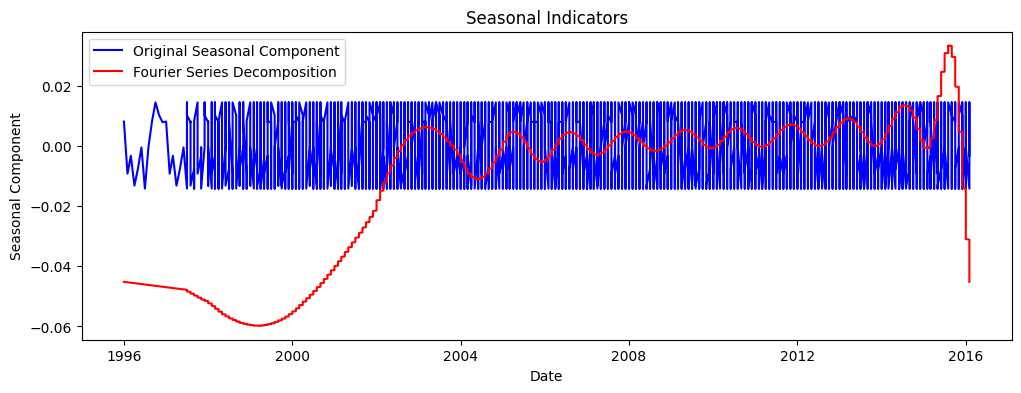

In [58]:
# Plot seasonal indicators
plt.figure(figsize=(12, 4))
plt.plot(decomposition.seasonal.index, decomposition.seasonal, label='Original Seasonal Component', color='blue')
plt.plot(decomposition.seasonal.index, seasonal_indicators, label='Fourier Series Decomposition', color='red')
plt.title('Seasonal Indicators')
plt.xlabel('Date')
plt.ylabel('Seasonal Component')
plt.legend()
plt.show()

#model training

In [59]:
!python -m pip install prophet

In [60]:
#import models SARIMA,ARIMA,Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [62]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Initialize and train models
arima_model = ARIMA(y_train, order=(5,1,0)).fit()
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')
prophet_model = Prophet()
prophet_model.fit(pd.DataFrame({'ds': X_train['date'], 'y': y_train}))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

#model evaluation

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# SARIMA evaluation
sarima_pred = sarima_model.forecast(steps=len(y_test))
sarima_mae = mean_absolute_error(y_test, sarima_pred)
sarima_mse = mean_squared_error(y_test, sarima_pred)
sarima_rmse = np.sqrt(sarima_mse)
# ARIMA evaluation
arima_pred = arima_model.forecast(steps=len(y_test))
arima_mae = mean_absolute_error(y_test, arima_pred)
arima_mse = mean_squared_error(y_test, arima_pred)
arima_rmse = np.sqrt(arima_mse)
# Prophet evaluation
future = prophet_model.make_future_dataframe(periods=len(y_test))
prophet_pred = prophet_model.predict(future)[-len(y_test):]
prophet_mae = mean_absolute_error(y_test, prophet_pred['yhat'])
prophet_mse = mean_squared_error(y_test, prophet_pred['yhat'])
prophet_rmse = np.sqrt(prophet_mse)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [64]:
#display the error values
print("SARIMA Model Evaluation:")
print(f"Mean Absolute Error (MAE): {sarima_mae}")
print(f"Mean Squared Error (MSE): {sarima_mse}")
print(f"Root Mean Squared Error (RMSE): {sarima_rmse}")

print("ARIMA Model Evaluation:")
print(f"Mean Absolute Error (MAE): {arima_mae}")
print(f"Mean Squared Error (MSE): {arima_mse}")
print(f"Root Mean Squared Error (RMSE): {arima_rmse}")

print("Prophet Model Evaluation:")
print(f"Mean Absolute Error (MAE): {prophet_mae}")
print(f"Mean Squared Error (MSE): {prophet_mse}")
print(f"Root Mean Squared Error (RMSE): {prophet_rmse}")

SARIMA Model Evaluation:
Mean Absolute Error (MAE): 0.7240307303713804
Mean Squared Error (MSE): 1.0864249302362214
Root Mean Squared Error (RMSE): 1.0423170967782411
ARIMA Model Evaluation:
Mean Absolute Error (MAE): 0.7412512252152903
Mean Squared Error (MSE): 1.0908864742259923
Root Mean Squared Error (RMSE): 1.0444551087653275
Prophet Model Evaluation:
Mean Absolute Error (MAE): 2.1830841999434574
Mean Squared Error (MSE): 7.381739442342424
Root Mean Squared Error (RMSE): 2.716935671366259
